# Un schéma volume fini pour l'équation de Darcy dans les milieu différents


In [65]:
import sys
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt

class Grid(object):
    def __init__(self, **kwds):
        self.__dict__.update(kwds)


### Condition aux bords

In [66]:
def addBC(A,f,K,hx,hy,bcL,bcR,bcU,bcD,solex,gradx,grady,LL):
    N = int(np.sqrt(A.shape[0]))    # la taille
    x = np.linspace(0,LL,N)    # discretisation
    y = np.linspace(0,LL,N)
    b = hx*hy*f
    if bcD == 'Dirichlet':  #bord en bas
        for i in range(N):
            A[i,i] += 2*K[1,N-1,i]*hx/hy
            b[i] += 2*K[1,N-1,i]*hx/hy*solex(x[i],0,LL)
            #print(2*K[1,0,i]*hx/hy*solex(x[i],0,LL))
    if bcD == 'Neumann':
        for i in range(N):
            b[i] -= K[1,N-1,i]*grady(x[i],0,LL)*hy
    if bcU == 'Dirichlet':  #bord en haut
        for i in range(1,N+1):
            A[-i,-i] += 2*K[1,0,-i]*hx/hy
            b[-i] += 2*K[1,0,-i]*hx/hy*solex(x[-i],LL,LL)
            #print(2*K[1,N-1,-i]*hx/hy*solex(x[-i],LL,LL))
    if bcU == 'Neumann':
        for i in range(1,N+1):
            b[-i] += K[1,0,-i]*grady(x[-i],LL,LL)*hy
    if bcL == 'Dirichlet':  # bord a gauche
        for i in range(N):
            A[N*i,N*i] += 2*K[0,-(i+1),0]*hy/hx
            b[N*i] += 2*K[0,-(i+1),0]*hy/hx*solex(0,y[i],LL)
            #print(2*K[0,i,0]*hy/hx*solex(0,y[i],LL))
    if bcL == 'Neumann':  
        for i in range(N):
            b[N*i] -= K[0,-(i+1),0]*gradx(0,y[i],LL)*hx
    if bcR == 'Dirichlet':  # bord a droite
        for i in range(1,N+1):
            A[N*i-1,N*i-1] += 2*K[0,N-i,N-1]*hy/hx
            b[N*i-1] +=  2*K[0,N-i,N-1]*hy/hx*solex(LL,y[i-1],LL)
            #print(2*K[0,i-1,N-1]*hy/hx*solex(LL,y[i-1],LL))
    if bcR == 'Neumann':
        for i in range(1,N+1):
            b[N*i-1] += K[0,N-i,N-1]*gradx(LL,y[i-1],LL)*hx
    return A,b

### TPFA

In [67]:
def TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex, gradx, grady, LL):
    Nx=grid.Nx; hx=grid.hx;
    Ny=grid.Ny; hy=grid.hy;
    N=Nx*Ny
    L=K**(-1)
    tx=2.*hy/hx; TX=np.zeros((Nx+1, Ny))
    ty=2.*hx/hy; TY=np.zeros((Nx, Ny+1))
    TX[1:Nx, :] = tx / (L[0, 0:Nx-1, :] + L[0, 1:Nx, :])
    TY[:, 1:Ny] = ty / (L[1, :, 0:Ny-1] + L[1, :, 1:Ny])
    
    x1=np.transpose(TX[0:Nx, :]).reshape(N)
    x2=np.transpose(TX[1:Nx+1, :]).reshape(N)
    y1=np.transpose(TY[:, 0:Ny]).reshape(N)
    y2=np.transpose(TY[:, 1:Ny+1]).reshape(N)

    DiagVecs = [-y2, -x2, x1+x2+y1+y2, -x1, -y1]
    A = sp.spdiags(DiagVecs, np.array((-Nx, -1, 0, 1, Nx)), N, N)
    A = sp.csr_matrix(A)
    A,f = addBC(A,f,K,hx,hy,bcL,bcR,bcU,bcD,solex,gradx,grady,LL)
    
    # quand on fait Dirichlet sur le coin en bas à gauche et en haut a droite
    """
    A[0,0] += 4*K[1,0,0]*hx/hy
    f[0] += 4*K[1,0,0]*hx/hy*solex(0,0,LL)
    A[N-1,N-1] += 4*K[1,int(np.sqrt(N)-1),int(np.sqrt(N)-1)]*hx/hy
    f[N-1] += 4*K[1,int(np.sqrt(N)-1),int(np.sqrt(N)-1)]*hx/hy*solex(x[int(np.sqrt(N)-1)],LL,LL)
    """

    u = spsolve(A, f)
    P = u.reshape((Nx, Ny))
    Vx = np.zeros((Nx+1, Ny))
    Vy = np.zeros((Nx, Ny+1))
    Vx[1:Nx, :] = (P[0:Nx-1, :] - P[1:Nx, :])*TX[1:Nx, :]
    Vy[:, 1:Ny] = (P[:, 0:Ny-1] - P[:, 1:Ny])*TY[:, 1:Ny]

    return(A, P, Vx, Vy)


### Solution exacte  $= (\frac{x}{L})^3+(\frac{y}{L})^3$ et son gradient

In [68]:
def solex1(x,y,L):
    return (x/L)**3+(y/L)**3

In [69]:
def gradx1(x,y,L):
    return 3*x**2/L**3

In [70]:
def grady1(x,y,L):
    return 3*y**2/L**3

### Validation

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


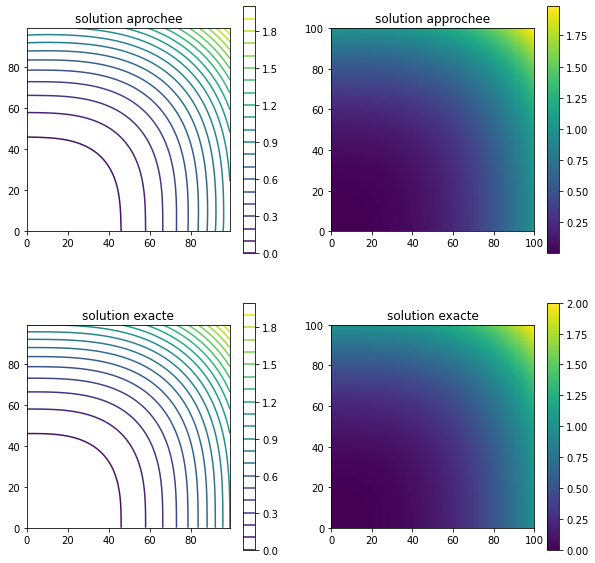

In [71]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

bcL = 'Dirichlet'   # bord a gauche
#bcL = 'Neumann'   
bcR = 'Dirichlet'   # bord a droite
#bcR = 'Neumann'
bcU = 'Dirichlet'   # bord en haut
#bcU = 'Neumann'
bcD = 'Dirichlet'   # bord en bas
#bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))  # permeabilite
K[0,:,:] *= 2

f = np.zeros(N)
x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = -(12*x[j]/LL**3+6*y[i]/LL**3)  # second membre
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex1, gradx1, grady1, LL)

sol_ex = np.zeros(N)
for i in range(n):
    for j in range(n):
        sol_ex[i*n+j] = x[j]**3/LL**3+y[i]**3/LL**3  #solution exacte
Pex = sol_ex.reshape((n,n))

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('solution aprochee')
plt.colorbar()
plt.subplot(222)
plt.pcolor(P)
plt.colorbar()
plt.gca().set_aspect('equal')
plt.title('solution approchee')
plt.subplot(223)
plt.contour(Pex,20)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('solution exacte')
plt.subplot(224)
plt.pcolor(Pex)
plt.colorbar()
plt.gca().set_aspect('equal')
plt.title('solution exacte')
plt.show()

### Erreur 

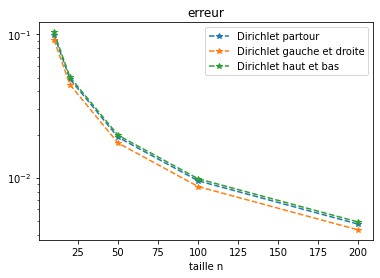

In [72]:
LL = 100.
err1 = []
err2 = []
err3 = []
taille = [10,20,50,100,200]
for n in taille:
    N=n*n;
    grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
    K=1*np.ones((2, grid.Nx, grid.Ny))
    K[0,:,:] *= 2
    f = np.zeros(N)
    x = np.linspace(0,LL,n)
    y = np.linspace(0,LL,n)
    sol_ex = np.zeros(N)
    for i in range(n):
        for j in range(n):
            f[i*n+j] = -(12*x[j]/LL**3+6*y[i]/LL**3)
            sol_ex[i*n+j] = x[j]**3/LL**3+y[i]**3/LL**3

    (A1, P1, Vx, Vy)=TPFA(grid, K, f, 'Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet', solex1, gradx1, grady1, LL)
    (A2, P2, Vx, Vy)=TPFA(grid, K, f, 'Dirichlet', 'Dirichlet', 'Neumann', 'Neumann', solex1, gradx1, grady1, LL)
    (A3, P3, Vx, Vy)=TPFA(grid, K, f, 'Neumann', 'Neumann', 'Dirichlet', 'Dirichlet', solex1, gradx1, grady1, LL)
    sol_ap1 = P1.reshape(N)
    sol_ap2 = P2.reshape(N)
    sol_ap3 = P3.reshape(N)
    err1.append(np.linalg.norm(sol_ex-sol_ap1)/np.linalg.norm(sol_ex))
    err2.append(np.linalg.norm(sol_ex-sol_ap2)/np.linalg.norm(sol_ex))
    err3.append(np.linalg.norm(sol_ex-sol_ap3)/np.linalg.norm(sol_ex))
plt.semilogy(taille,err1,'*--',label = 'Dirichlet partour')
plt.semilogy(taille,err2,'*--',label = 'Dirichlet gauche et droite')
plt.semilogy(taille,err3,'*--',label = 'Dirichlet haut et bas')
plt.title('erreur')
plt.xlabel('taille n')
plt.legend()
plt.show()

# Premier exmeple 

## cas homogène 

### Dirichlet en haut et en bas, avec une différence de pression de 1, Neumann à droite et à gauche

In [73]:
def solex2(x,y,L):
    return y/100+99

In [74]:
def gradx2(x,y,L):
    return 0

In [75]:
def grady2(x,y,L):
    return 0.01

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


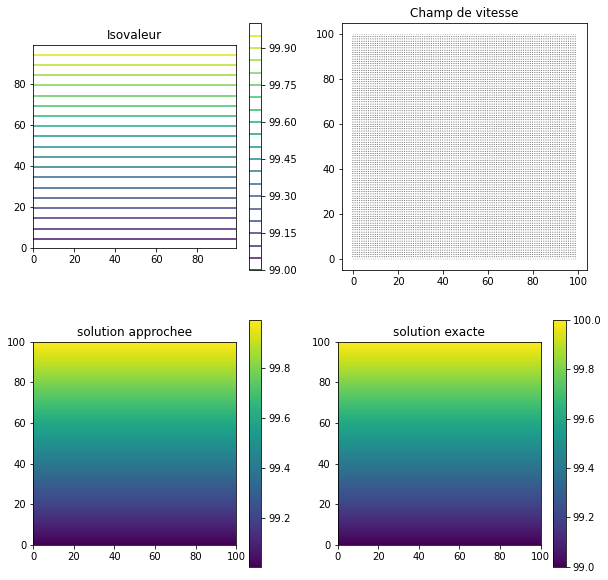

In [76]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

#bcL = 'Dirichlet'
bcL = 'Neumann'
#bcR = 'Dirichlet'
bcR = 'Neumann'
bcU = 'Dirichlet'
#bcU = 'Neumann'
bcD = 'Dirichlet'
#bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
f = np.zeros(N)
sol_ex = np.zeros(N)
x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = 0
        sol_ex[i*n+j] = y[i]/100+99  #solution exacte
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex2, gradx2, grady2, LL)
Pex = sol_ex.reshape((n,n))

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()
plt.subplot(222)
plt.quiver(Vx, Vy)
plt.gca().set_aspect('equal')
plt.title('Champ de vitesse')
plt.subplot(223)
plt.pcolor(P)
plt.colorbar()
plt.title('solution approchee')
plt.gca().set_aspect('equal')
plt.subplot(224)
plt.pcolor(Pex)
plt.colorbar()
plt.title('solution exacte')
plt.gca().set_aspect('equal')
plt.show()

### Dirichlet à droite et à gauche , avec une différence de pression 1 et Neumann en haut et en bas

In [77]:
def solex3(x,y,L):
    return np.cos(0.005*np.pi*x)

In [78]:
def gradx3(x,y,L):
    return -0.005*np.pi*np.sin(0.005*np.pi*x)

In [79]:
def grady3(x,y,L):
    return 0

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


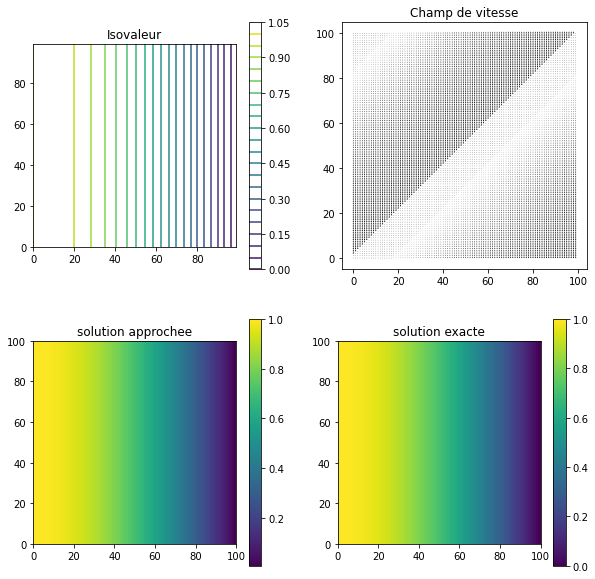

In [80]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

bcL = 'Dirichlet'
#bcL = 'Neumann'
bcR = 'Dirichlet'
#bcR = 'Neumann'
#bcU = 'Dirichlet'
bcU = 'Neumann'
#bcD = 'Dirichlet'
bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
f = np.zeros(N)
sol_ex = np.zeros(N)
x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = 0.005*0.005*np.pi*np.pi*np.cos(0.005*np.pi*x[j])
        sol_ex[i*n+j] = np.cos(0.005*np.pi*x[j])  #solution exacte
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex3, gradx3, grady3, LL)
Pex = sol_ex.reshape((n,n))


plt.figure(figsize=(10,10))
plt.subplot(221)
plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()
plt.subplot(222)
plt.quiver(Vx, Vy)
plt.gca().set_aspect('equal')
plt.title('Champ de vitesse')
plt.subplot(223)
plt.pcolor(P)
plt.colorbar()
plt.title('solution approchee')
plt.gca().set_aspect('equal')
plt.subplot(224)
plt.pcolor(Pex)
plt.colorbar()
plt.title('solution exacte')
plt.gca().set_aspect('equal')
plt.show()

### Dirichlet autour des coins en bas à gauche et en haut à droite et Neumann ailleurs

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


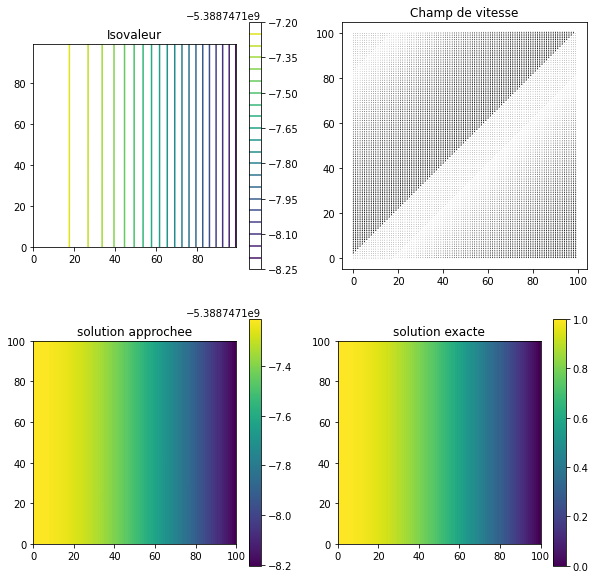

In [81]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

#bcL = 'Dirichlet'
bcL = 'Neumann'
#bcR = 'Dirichlet'
bcR = 'Neumann'
#bcU = 'Dirichlet'
bcU = 'Neumann'
#bcD = 'Dirichlet'
bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
f = np.zeros(N)
sol_ex = np.zeros(N)
x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = 0.005*0.005*np.pi*np.pi*np.cos(0.005*np.pi*x[j])
        sol_ex[i*n+j] = np.cos(0.005*np.pi*x[j])  #solution exacte
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex3, gradx3, grady3, LL)
Pex = sol_ex.reshape((n,n))


plt.figure(figsize=(10,10))
plt.subplot(221)
plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()
plt.subplot(222)
plt.quiver(Vx, Vy)
plt.gca().set_aspect('equal')
plt.title('Champ de vitesse')
plt.subplot(223)
plt.pcolor(P)
plt.colorbar()
plt.title('solution approchee')
plt.gca().set_aspect('equal')
plt.subplot(224)
plt.pcolor(Pex)
plt.colorbar()
plt.title('solution exacte')
plt.gca().set_aspect('equal')
plt.show()

## Cas hétérogène

### K = $10^{-5}$ m/d

### Dirichlet en haut et en bas et Neumann à droite et à gauche

In [82]:
def solex4(x,y,L):
    return np.exp(x/L+y/L)

In [83]:
def gradx4(x,y,L):
    return 1/L*np.exp(x/L+y/L)

In [84]:
def grady4(x,y,L):
    return 1/L*np.exp(x/L+y/L)

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


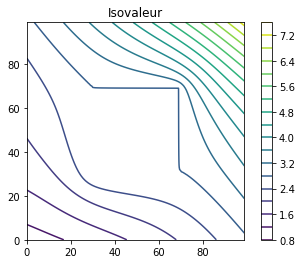

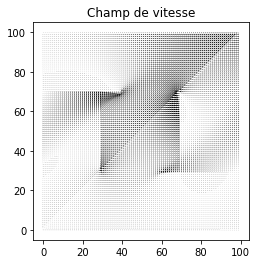

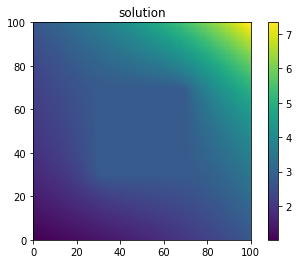

In [85]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

#bcL = 'Dirichlet'
bcL = 'Neumann'
#bcR = 'Dirichlet'
bcR = 'Neumann'
bcU = 'Dirichlet'
#bcU = 'Neumann'
bcD = 'Dirichlet'
#bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(30,70):
    for j in range(30,70):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = -2/LL**2*np.exp(x[j]/LL+y[i]/LL)
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex4, gradx4, grady4, LL)


plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()

plt.figure(2)
plt.quiver(Vx, Vy)
plt.gca().set_aspect('equal')
plt.title('Champ de vitesse')

plt.figure(3)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

### Dirichlet à droite et à gauche et Neumann en haut et en bas

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


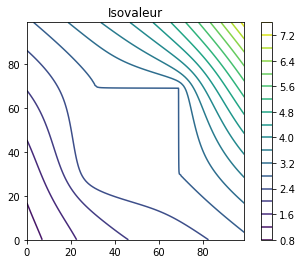

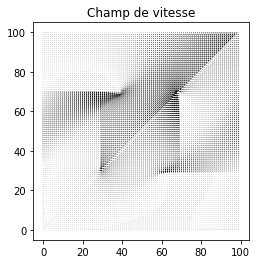

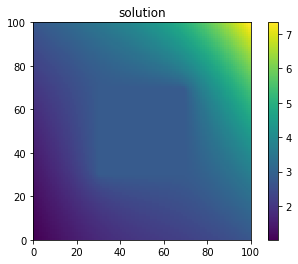

In [86]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

bcL = 'Dirichlet'
#bcL = 'Neumann'
bcR = 'Dirichlet'
#bcR = 'Neumann'
#bcU = 'Dirichlet'
bcU = 'Neumann'
#bcD = 'Dirichlet'
bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(30,70):
    for j in range(30,70):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = -2/LL**2*np.exp(x[j]/LL+y[i]/LL)
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex4, gradx4, grady4, LL)


plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()

plt.figure(2)
plt.quiver(Vx, Vy)
plt.gca().set_aspect('equal')
plt.title('Champ de vitesse')

plt.figure(3)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

### Dirichlet autour des coins en bas à gauche et en haut à droite et Neumann ailleurs

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


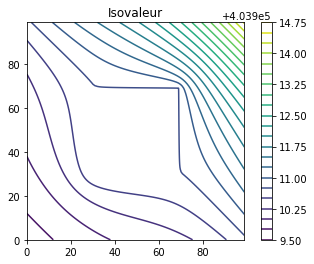

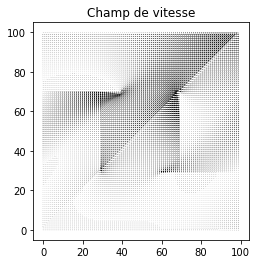

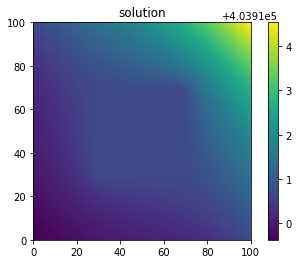

In [87]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

#bcL = 'Dirichlet'
bcL = 'Neumann'
#bcR = 'Dirichlet'
bcR = 'Neumann'
#bcU = 'Dirichlet'
bcU = 'Neumann'
#bcD = 'Dirichlet'
bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(30,70):
    for j in range(30,70):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = -2/LL**2*np.exp(x[j]/LL+y[i]/LL)
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex4, gradx4, grady4, LL)


plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()

plt.figure(2)
plt.quiver(Vx, Vy)
plt.gca().set_aspect('equal')
plt.title('Champ de vitesse')

plt.figure(3)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

###  $K = 10^5 m/d$

### Dirichlet en haut et en bas et Neumann à droite et à gauche

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


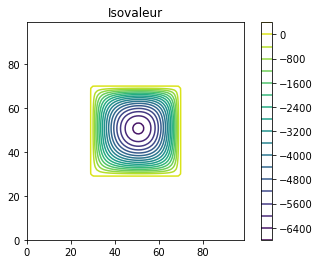

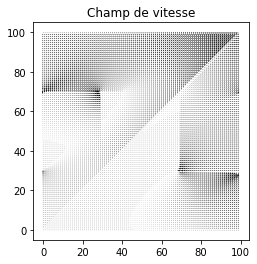

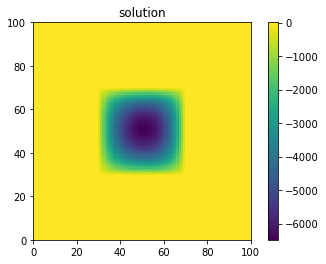

In [88]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

#bcL = 'Dirichlet'
bcL = 'Neumann'
#bcR = 'Dirichlet'
bcR = 'Neumann'
bcU = 'Dirichlet'
#bcU = 'Neumann'
bcD = 'Dirichlet'
#bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(30,70):
    for j in range(30,70):
        K[0,i,j] = 1e-5
        K[1,i,j] = 1e-5
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = -2/LL**2*np.exp(x[j]/LL+y[i]/LL)
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex4, gradx4, grady4, LL)


plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()

plt.figure(2)
plt.quiver(Vx, Vy)
plt.gca().set_aspect('equal')
plt.title('Champ de vitesse')

plt.figure(3)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

### Dirichlet à droite et à gauche et Neumann en haut et en bas

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


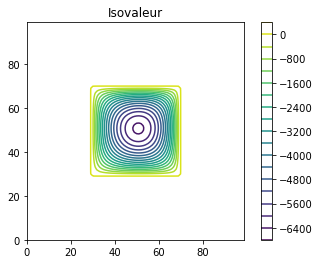

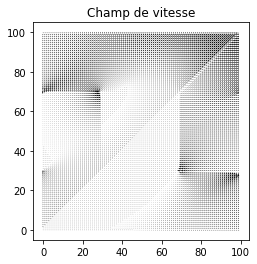

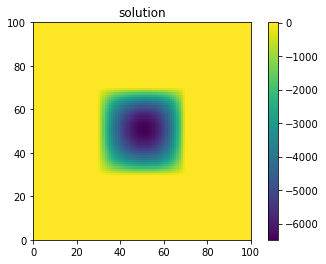

In [89]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

bcL = 'Dirichlet'
#bcL = 'Neumann'
bcR = 'Dirichlet'
#bcR = 'Neumann'
#bcU = 'Dirichlet'
bcU = 'Neumann'
#bcD = 'Dirichlet'
bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(30,70):
    for j in range(30,70):
        K[0,i,j] = 1e-5
        K[1,i,j] = 1e-5
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = -2/LL**2*np.exp(x[j]/LL+y[i]/LL)
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex4, gradx4, grady4, LL)


plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()

plt.figure(2)
plt.quiver(Vx, Vy)
plt.gca().set_aspect('equal')
plt.title('Champ de vitesse')

plt.figure(3)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

### Dirichlet autour des coins en bas à gauche et en haut à droite et Neumann ailleurs

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


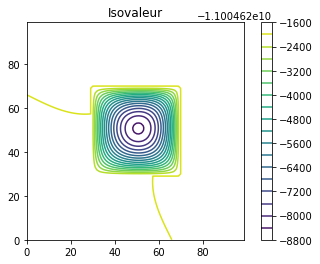

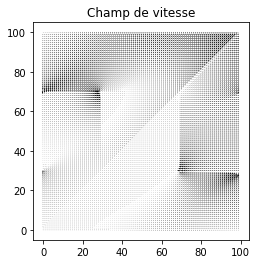

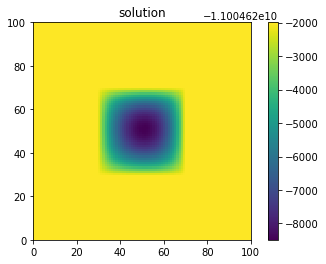

In [90]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

#bcL = 'Dirichlet'
bcL = 'Neumann'
#bcR = 'Dirichlet'
bcR = 'Neumann'
#bcU = 'Dirichlet'
bcU = 'Neumann'
#bcD = 'Dirichlet'
bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(30,70):
    for j in range(30,70):
        K[0,i,j] = 1e-5
        K[1,i,j] = 1e-5
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = -2/LL**2*np.exp(x[j]/LL+y[i]/LL)
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex4, gradx4, grady4, LL)


plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()

plt.figure(2)
plt.quiver(Vx, Vy)
plt.gca().set_aspect('equal')
plt.title('Champ de vitesse')

plt.figure(3)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

# Deuxième cas

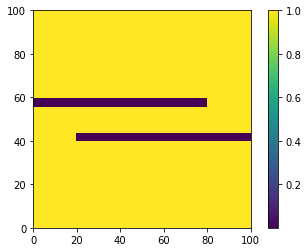

In [91]:
K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(40,44):
    for j in range(20,100):
        K[0,i,j] = 1e-5
        K[1,i,j] = 1e-5
for i in range(56,60):
    for j in range(80):
        K[0,i,j] = 1e-5
        K[1,i,j] = 1e-5
plt.pcolor(K[0,:,:])
plt.colorbar()
plt.gca().set_aspect('equal')


Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


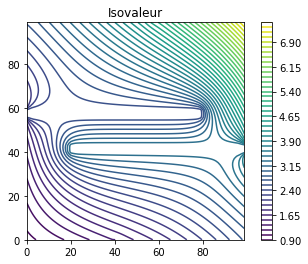

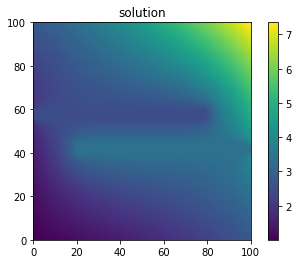

In [92]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

bcL = 'Dirichlet'
#bcL = 'Neumann'
bcR = 'Dirichlet'
#bcR = 'Neumann'
bcU = 'Dirichlet'
#bcU = 'Neumann'
bcD = 'Dirichlet'
#bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(20,100):
    for j in range(40,44):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
for i in range(80):
    for j in range(56,60):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = -2/LL**2*np.exp(x[j]/LL+y[i]/LL)
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex4, gradx4, grady4, LL)


plt.contour(P,50)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()

plt.figure(3)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


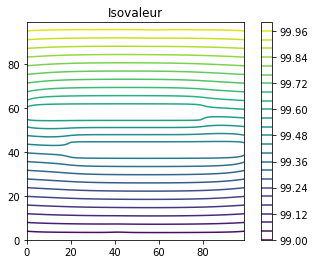

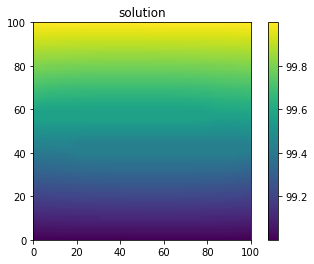

In [93]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

bcL = 'Dirichlet'
#bcL = 'Neumann'
bcR = 'Dirichlet'
#bcR = 'Neumann'
bcU = 'Dirichlet'
#bcU = 'Neumann'
bcD = 'Dirichlet'
#bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(20,100):
    for j in range(40,44):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
for i in range(80):
    for j in range(56,60):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = 0
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex2, gradx2, grady2, LL)


plt.contour(P,30)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()

plt.figure(3)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

# Troisième cas

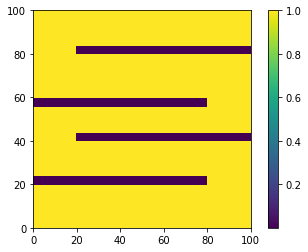

In [96]:
K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(20,24):
    for j in range(80):
        K[0,i,j] = 1e-5
        K[1,i,j] = 1e-5
for i in range(40,44):
    for j in range(20,100):
        K[0,i,j] = 1e-5
        K[1,i,j] = 1e-5
for i in range(56,60):
    for j in range(80):
        K[0,i,j] = 1e-5
        K[1,i,j] = 1e-5
for i in range(80,84):
    for j in range(20,100):
        K[0,i,j] = 1e-5
        K[1,i,j] = 1e-5
plt.pcolor(K[0,:,:])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

In [97]:
def solex5(x,y,L):
    return x**2/L**2+y**2/L**2-1

In [98]:
def gradx5(x,y,L):
    return 2*x/L**2

In [99]:
def grady5(x,y,L):
    return 2*y/L**2

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


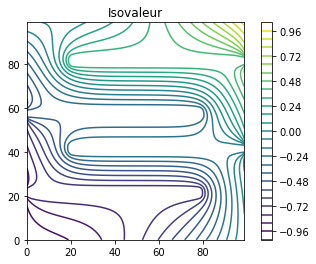

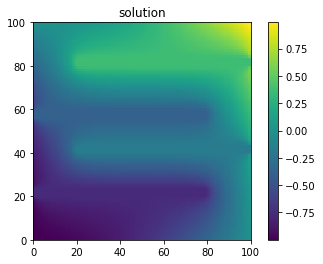

In [100]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

bcL = 'Dirichlet'
#bcL = 'Neumann'
bcR = 'Dirichlet'
#bcR = 'Neumann'
bcU = 'Dirichlet'
#bcU = 'Neumann'
bcD = 'Dirichlet'
#bcD = 'Neumann'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(80):
    for j in range(20,24):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
for i in range(20,100):
    for j in range(40,44):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
for i in range(80):
    for j in range(56,60):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
for i in range(20,100):
    for j in range(80,84):
        K[0,i,j] = 1e5
        K[1,i,j] = 1e5
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = -4/LL**2
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex5, gradx5, grady5, LL)


plt.contour(P,30)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()

plt.figure(3)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

In [101]:
def solex6(x,y,L):
    if x == 0:
        return 0
    if x == L:
        return 0
    if y == 0:
        return 0
    if y == L:
        return 1

In [102]:
def gradx6(x,y,L):
    return 0

In [103]:
def grady6(x,y,L):
    return 0

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


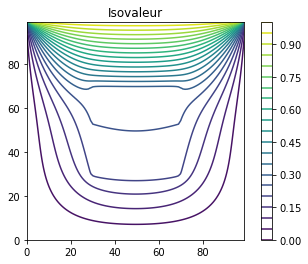

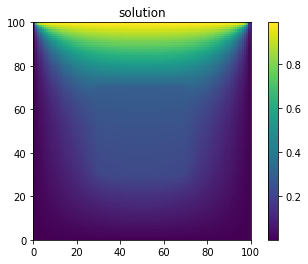

In [104]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

bcL = 'Dirichlet'

bcR = 'Dirichlet'

bcU = 'Dirichlet'

bcD = 'Dirichlet'

K=1*np.ones((2, grid.Nx, grid.Ny))
for i in range(30,70):
    for j in range(30,70):
        K[0,i,j] = 1e1
        K[1,i,j] = 1e1
        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = 0
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex6, gradx6, grady6, LL)


plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()


plt.figure(2)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()

Nx=  100  Ny= 100  hx= 1.0  hy= 1.0


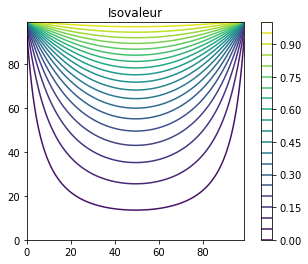

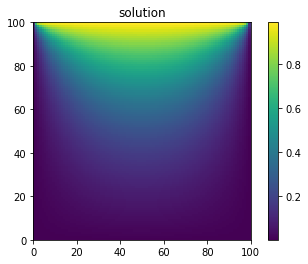

In [105]:
LL = 100.
n=100; N=n*n;
grid = Grid(Nx=n, Ny=n, hx=LL/n, hy=LL/n)
print("Nx= ", grid.Nx, " Ny=", grid.Ny, " hx=", grid.hx, " hy=", grid.hy)

bcL = 'Dirichlet'

bcR = 'Dirichlet'

bcU = 'Dirichlet'

bcD = 'Dirichlet'

K=1*np.ones((2, grid.Nx, grid.Ny))

        
f = np.zeros(N)

x = np.linspace(0,LL,n)
y = np.linspace(0,LL,n)
for i in range(n):
    for j in range(n):
        f[i*n+j] = 0
        
        
(A, P, Vx, Vy)=TPFA(grid, K, f, bcL, bcR, bcU, bcD, solex6, gradx6, grady6, LL)


plt.contour(P,20)
plt.gca().set_aspect('equal')
plt.title('Isovaleur')
plt.colorbar()


plt.figure(2)
plt.pcolor(P)
plt.colorbar()
plt.title('solution')
plt.gca().set_aspect('equal')
plt.show()